### 1. Import Required Libraries

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

### 2. Define OLED Simulation Environment

In [2]:
lambda_min = 0.4  # 최소 파장 (μm)
lambda_max = 0.7  # 최대 파장 (μm)
fmin = 1 / lambda_max  # 최소 주파수 (1/μm)
fmax = 1 / lambda_min  # 최대 주파수 (1/μm)
fcen = 0.5 * (fmin + fmax)  # 중심 주파수
df = fmax - fmin  # 주파수 폭
# 주파수를 파장으로 변환
# resolution = 33 # 1um/0.03um = 33
resolution = 200 # 1um/200 = 0.002um = 5nm
nfreq = 25


### 3. Define OLED Layer Materials, Thickness

In [20]:
### ----- Refractive index ----- ###
Glass = mp.Medium(index=1.5) # SiO2 임의값
CoverLayer = mp.Medium(index=1.0) # SiN
Cathode = mp.Medium(index=1.2)  # Al 임의값 1.1978
aNDP = mp.Medium(index= 1.5)  # aNDP (aNPD_PFA (380 - 780 nm) 임의값 
ITO = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기


### ----- Thickness ----- ###
tPML = round(lambda_max * 0.5, 3)  # 0.35
tGlass = round(1.37, 2) #뒤에서 PML까지 연장해야함
tCoverLayer = round(0.07, 3)
tITO = round(0.15, 3)
tNDP = round(0.05, 3)
tAlq3 = round(0.06, 3)
tCathode = round(0.3, 3)

tOLED = round(tGlass + tCoverLayer + tITO + tNDP + tAlq3 + tCathode, 3)

### ----- Simulation region ----- ###
Sx = round(30, 3)
Sy = round(0, 3)
Sz = round(tOLED+tPML, 3)

cell_size = mp.Vector3(Sx, Sy, Sz)

print("cell_size: ", cell_size)
print("tPML: ", tPML)
print("tGlass: ", tGlass)
print("tCoverLayer: ", tCoverLayer)
print("tITO: ", tITO)
print("tNDP: ", tNDP)
print("tAlq3: ", tAlq3)
print("tCathode: ", tCathode)
print("tOLED: ", tOLED)

cell_size:  Vector3<30.0, 0.0, 2.35>
tPML:  0.35
tGlass:  1.37
tCoverLayer:  0.07
tITO:  0.15
tNDP:  0.05
tAlq3:  0.06
tCathode:  0.3
tOLED:  2.0


### 4. Define Boundary Conditions (PML)


In [21]:
# PML 경계조건
boundary_layers = [mp.PML(tPML, direction=mp.X),
                   mp.PML(tPML, direction=mp.Z, side=mp.High)] 

### 5. Define OLED Geometry, Structure


In [22]:
# OLED 구조 정의 (Lumerical 반영)
# geometry = [
#     mp.Block(material=Air,
#              size=mp.Vector3(Sx, Sy, tAir),
#              center=mp.Vector3(z=tCathode/2 + tAlq3 + tNDP + tITO + tCoverLayer + tGlass + tAir/2)),

#     mp.Block(material=Glass,
#              size=mp.Vector3(Sx, Sy, tGlass),
#              center=mp.Vector3(z=tCathode/2 + tAlq3 + tNDP + tITO + tCoverLayer + tGlass/2)),

#     mp.Block(material=CoverLayer,
#              size=mp.Vector3(Sx, Sy, tCoverLayer),
#              center=mp.Vector3(z=tCathode/2 + tAlq3 + tNDP + tITO + tCoverLayer/2)),
    
#     mp.Block(material=ITO,
#              size=mp.Vector3(Sx, Sy, tITO),
#              center=mp.Vector3(z=tCathode/2 + tAlq3 + tNDP + tITO/2)),
    
#     mp.Block(material=aNDP,
#              size=mp.Vector3(Sx, Sy, tNDP),
#              center=mp.Vector3(z=tCathode/2 + tAlq3 + tNDP/2)),

#     mp.Block(material=Alq3,
#              size=mp.Vector3(Sx, Sy, tAlq3),
#              center=mp.Vector3(z=tCathode/2 + tAlq3/2)),

#     mp.Block(material=Cathode,
#              size=mp.Vector3(Sx, Sy, tCathode),
#              center=mp.Vector3(z=0)),
# ]


first_layer = -(Sz/2)
geometry = [
    mp.Block(material=Glass,
             size=mp.Vector3(Sx, Sy, tGlass+tPML),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3 + tNDP + tITO + tCoverLayer + (tGlass+tPML)/2)),

    mp.Block(material=CoverLayer,
             size=mp.Vector3(Sx, Sy, tCoverLayer),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3 + tNDP + tITO + tCoverLayer/2)),
    
    mp.Block(material=ITO,
             size=mp.Vector3(Sx, Sy, tITO),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3 + tNDP + tITO/2)),
    
    mp.Block(material=aNDP,
             size=mp.Vector3(Sx, Sy, tNDP),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3 + tNDP/2)),

    mp.Block(material=Alq3,
             size=mp.Vector3(Sx, Sy, tAlq3),
             center=mp.Vector3(z=first_layer + tCathode + tAlq3/2)),

    mp.Block(material=Cathode,
             size=mp.Vector3(Sx, Sy, tCathode),
             center=mp.Vector3(z=first_layer + tCathode/2)),
]

In [23]:
print("geometry: ", first_layer + tCathode + tAlq3 + tNDP + tITO + tCoverLayer + (tGlass+tPML)/2)

geometry:  0.31500000000000017


### 6. Define Light Source (Dipole Source)

In [24]:
### ----- 다이폴 소스 설정 (OLED 발광층에서 발생) ----- ###
'''Lumerial에서 0.33에 위치함 -> Cathode/2 = 0.3 & Alq3/2 = 0.03 '''

dipole_z = first_layer + tCathode + tAlq3/2  # 다이폴이 위치할 평면
single_dipole = True  # True: single dipole, False: multiple dipoles
num_dipoles = 1  # Number of dipoles, 1개로 동작 함

if single_dipole:
    sources = [mp.Source(mp.ContinuousSource(fcen),
                     component=mp.Ez,
                     center=mp.Vector3(x=0, z=dipole_z))]
else:
    dipole_x_positions = [i * (Sx / (num_dipoles + 1)) - Sx / 2 for i in range(1, num_dipoles + 1)]
    sources = [
        mp.Source(mp.ContinuousSource(frequency=1.0),
                component=mp.Ez,
                center=mp.Vector3(x=x_pos, z=dipole_z))
        for x_pos in dipole_x_positions]

     block, center = (0,0,0.315)
          size (30,0,1.72)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,-0.58)
          size (30,0,0.07)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-0.69)
          size (30,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,0,-0.79)
          size (30,0,0.05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,-0.845)
          size (30,0,0.06)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block

, center = (0,0,-1.025)
          size (30,0,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.44,1.44,1.44)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000512123 s
Working in 3D dimensions.
Computational cell is 30 x 0.005 x 2.35 with resolution 200
     block, center = (0,0,0.315)
          size (30,0,1.72)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,-0.58)
          size (30,0,0.07)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-0.69)
          size (30,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,0,-0.79)
          size (30,0,0.05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, ce

<Axes: xlabel='X', ylabel='Z'>

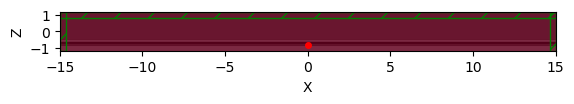

In [25]:
#test

# === 시뮬레이션 설정 === #
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    eps_averaging=False)

sim.plot2D(fields=mp.Ez, output_plane=mp.Volume(center=mp.Vector3(y=0), size=mp.Vector3(Sx, 0, Sz)))

### 7. Flux Monitors 

In [8]:
fluxbox_dpad = 0.02

sim_t = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    eps_averaging=False)

# Flux monitors
trans_flux = sim_t.add_flux(fcen, df, nfreq,
    mp.FluxRegion(center=mp.Vector3(0, 0, fluxbox_dpad/2), size=mp.Vector3(fluxbox_dpad, 0, 0)))  # 위쪽 (z+)

refl_flux = sim_t.add_flux(fcen, df, nfreq,
    mp.FluxRegion(center=mp.Vector3(0, 0, -fluxbox_dpad/2), size=mp.Vector3(fluxbox_dpad, 0, 0)))  # 아래쪽 (z-)

side_left_flux = sim_t.add_flux(fcen, df, nfreq,
    mp.FluxRegion(center=mp.Vector3(-fluxbox_dpad/2 , 0, 0), size=mp.Vector3(0, 0, fluxbox_dpad)))  # x1 왼쪽

side_right_flux = sim_t.add_flux(fcen, df, nfreq,
    mp.FluxRegion(center=mp.Vector3(fluxbox_dpad/2 , 0, 0), size=mp.Vector3(0, 0, fluxbox_dpad)))  # x2 오른쪽

harminv_monitor = mp.Harminv(mp.Ez,
                             mp.Vector3(0, 0, dipole_z),
                             fcen, df)



     block, center = (0,0,-0.195)
          size (30,0,1.72)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,-1.09)
          size (30,0,0.07)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-1.2)
          size (30,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,0,-1.3)
          size (30,0,0.05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,-1.355)
          size (30,0,0.06)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,0,-1.535)
          size (30,0,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.44,1.44,1.44)
-

<Axes: xlabel='X', ylabel='Z'>

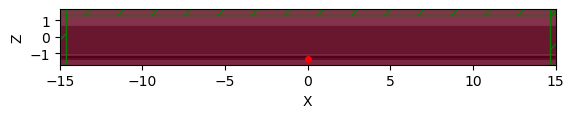

In [9]:
sim_t.plot2D(fields=mp.Ez, output_plane=mp.Volume(center=mp.Vector3(y=0), size=mp.Vector3(Sx, 0, Sz)))

### 8. Run the Simulation


In [10]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    eps_averaging=False)

# === OLED 시뮬레이션 실행 === #
mp.verbosity(2)
sim.reset_meep()
sim.run(until=100.0)

# === Flux 데이터 수집 === #
flux_glass = np.asarray(mp.get_fluxes(trans_flux))
flux_total = np.sum(flux_glass)  # 총 방출된 빛의 양

# === 주파수를 파장으로 변환 === #
freqs = np.linspace(fmin, fmax, len(flux_glass))  # 기존 주파수 값
wavelengths = 1 / freqs  # 파장 변환 (단위: μm)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000550032 s
Working in 3D dimensions.
Computational cell is 30 x 0.005 x 3.37 with resolution 200
     block, center = (0,0,-0.195)
          size (30,0,1.72)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,-1.09)
          size (30,0,0.07)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-1.2)
          size (30,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,0,-1.3)
          size (30,0,0.05)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,-1.355)
          size (30,0,0.06)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224

KeyboardInterrupt: 

### 9. Visualization of Results

In [ ]:
def plot_geometry_2D(sim, plane='XZ'):
    """ OLED 구조를 XZ 또는 YZ 평면에서 시각화 """
    eps_data = sim.get_epsilon()
    plt.figure(figsize=(8,6), dpi=100)
    
    if plane == 'XZ':
        plt.imshow(eps_data[:, int(resolution/2), :].T, origin="lower", cmap="inferno",
                   extent=(-sxy/2, sxy/2, 0, sz))
        plt.xlabel("X Position (μm)")
        plt.ylabel("Z Position (μm)")
        plt.title("OLED structure (XZ Plane)")
        
    elif plane == 'YZ':
        plt.imshow(eps_data[int(resolution/2), :, :].T, origin="lower", cmap="inferno",
                   extent=(-sxy/2, sxy/2, 0, sz))
        plt.xlabel("Y Position (μm)")
        plt.ylabel("Z Position (μm)")
        plt.title("OLED structure (YZ Plane)")
    
    plt.colorbar(label="Relative Permittivity")
    plt.show()

def plot_dipole_source():
    plt.figure(figsize=(6,3))
    plt.scatter(0, 0.5*sz-tPML-tGLS-tITO-0.5*tORG, color="red", marker="o", label="Dipole Source")
    plt.axhline(0.5*sz-tPML-tGLS-tITO-0.5*tORG, color="gray", linestyle="--")
    plt.xlabel("X Position")
    plt.ylabel("Z Position")
    plt.title("Dipole Source 위치")
    plt.legend()
    plt.grid()
    plt.show()

# === 전기장 (Ez 필드) 시각화 === #
def plot_electric_field(sim):
    """ 전기장 분포 (|Ez|²) 시각화 """
    Ez_data = np.abs(sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ez))**2
    plt.figure(figsize=(8,6))
    plt.imshow(Ez_data[:,:,int(sim.resolution/2)].T, origin="lower", cmap="plasma", extent=(-L/2, L/2, -L/2, L/2))
    plt.colorbar(label="|Ez|²")
    plt.title("Electric Field Distribution |Ez|²")
    plt.xlabel("X Position (μm)")
    plt.ylabel("Y Position (μm)")
    plt.show()

# === Flux 결과 시각화 (파장 기반) === #
def plot_flux_results(flux_glass, flux_waveguide, flux_total):
    plt.figure(figsize=(8,5))
    plt.plot(wavelengths, flux_glass, label="Extracted Light (Glass Region)", color="blue")
    plt.plot(freqs, flux_waveguide, label="Waveguide Mode", color="red", linestyle="dashed")
    plt.plot(wavelengths, flux_total * np.ones(len(wavelengths)), label="Total Flux", color="green", linestyle="dotted")

    plt.xlabel("Wavelength (μm)")  # X축을 파장으로 변경
    plt.ylabel("Flux")
    plt.title("Flux Analysis of OLED Emission")
    plt.legend()
    plt.grid()
    plt.show()

# === 시각화 실행 === #
plot_geometry_2D(sim, plane='XZ')  # XZ 단면 시각화
plot_geometry_2D(sim, plane='YZ')  # YZ 단면 시각화
plot_dipole_source()        # 2. 다이폴 소스 위치
plot_electric_field(sim)  # 전기장 분포 시각화
plot_flux_results(flux_glass, flux_total)  # OLED 광추출효율(LEE) 그래프